## Focus
### Pablo Ortiz
Thursday February 7, 2019

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/Users/pabloortiz/anaconda/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
def grabImage(sid=1, imres=8):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD='ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    #pop=skimage.transform.rotate(pop,180)
    return pop

In [3]:
def moveFocus(sid=0, step=1):
    sid += 1
    cmD='ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py '+str(sid)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    print(cmD)
    return pop.stdout
def resetFocus(sid=0):
    sid += 1
    cmD='ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/resetFocusMotor.py '+str(sid)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    print(cmD)
    return pop.stdout

In [4]:
def focusMetric(ss = 0):
    pip=grabImage(sid=ss, imres=8)
    pop=np.sum(np.abs(skimage.filters.laplace(pip[:,:,1])))
    return pop

In [5]:
def autofocus(sid = 0, initial_step = -200, num_intervals = 10, reset = True):
    moveFocus(sid = sid, step = initial_step)
    pop = np.zeros(num_intervals)
    dist = np.zeros(num_intervals)
    pop[0] = focusMetric(ss = sid)
    dist[0] = initial_step
    print('ctt: 0')
    print('Focus Metric: ' + str(pop[0]))
    print('Position: ' + str(dist[0]))
    for ctt in range(1, num_intervals):
        moveFocus(sid = sid, step = int(-2 * initial_step / (num_intervals - 1)))
        dist[ctt] = dist[ctt - 1] - int(2 * initial_step / (num_intervals - 1))
        pop[ctt] = focusMetric(ss = sid)
        print('ctt: ' + str(ctt))
        print('Focus Metric: ' + str(pop[ctt]))
        print('Position: ' + str(dist[ctt]))
    resetFocus(sid = sid)
    (maxp, idx) = max((v,i) for i,v in enumerate(pop))
    print('Focus occurs at ' + str(dist[idx]))
    print('Focus Metric at that point is ' + str(maxp))
    focusMetric(ss = 0) #Just here to kill time and allow the reset to settle in
    moveFocus(sid = sid, step = int(dist[idx]))
    pip=grabImage(sid = sid)
    print('Measured Focus Metric at that point is ' + str(np.sum(np.abs(skimage.filters.laplace(pip[:,:,1])))))

    if reset:
        resetFocus(sid = sid)
    return pop, dist, maxp, idx, pip


ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/resetFocusMotor.py 2"
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 -200"
ctt: 0
Focus Metric: 86754.47843137252
Position: -200.0
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 44"
ctt: 1
Focus Metric: 86986.20392156868
Position: -156.0
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 44"
ctt: 2
Focus Metric: 87572.20000000004
Position: -112.0
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 44"
ctt: 3
Focus Metric: 92182.52156862753
Position: -68.0
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 44"
ctt: 4
Focus Metric: 109370.90588235272
Position: -24.0
ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "python2 ~/bin/moveFocusMotor.py 2 44"
ctt: 5
Focus Metric: 176429.04313725478
Position: 20.0
ssh -i ~/.ssh/id_rsa_n

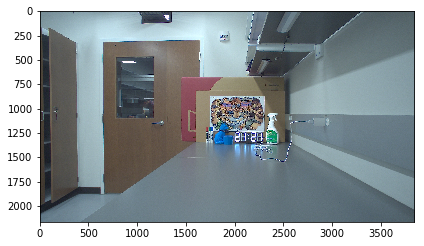

In [6]:
camera = 1
resetFocus(sid = camera)
focusMetric(ss = camera) #Just here to kill time and allow the reset to settle in
[pop, dist, maxp, idx, pip] = autofocus(sid = camera, reset = False, initial_step = -200, num_intervals = 10)
imio.imshow(pip)

In [7]:
def grabImageExpo(sid=1, imres=8, expoTime=0.500):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD='ssh -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --exposure-time='+str(expoTime)+' --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp -i ~/.ssh/id_rsa_nopassword nvidia@10.236.176.38:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    #pop=skimage.transform.rotate(pop,180)
    return pop

In [8]:
def exposureMetric(ss = 0, expoTime = 0.5):
    pip=grabImageExpo(sid=ss, imres=8, expoTime = expoTime)
    average_pixel = np.average(np.hstack(pip[:, :, 1]))
    error = average_pixel - 128
    return abs(error)

In [9]:
def autoexposure(sid = 0, max_exposure = 1, num_intervals = 10):
    pop = np.zeros(num_intervals)
    exp = np.zeros(num_intervals)
    for ctt in range(num_intervals):
        exp[ctt] = ctt / (num_intervals - 1) * max_exposure
        pop[ctt] = exposureMetric(ss = sid, expoTime = exp[ctt])
        print('ctt: ' + str(ctt))
        print('Exposure: ' + str(exp[ctt]))
        print('Histogram Metric: ' + str(pop[ctt]))
    (minp, idx) = min((v,i) for i,v in enumerate(pop))
    print('Histogram center occurs at ' + str(exp[idx]))
    print('Histogram Metric at that point is ' + str(minp))
    pip=grabImageExpo(sid = sid, expoTime = exp[idx])

    return pop, dist, maxp, idx, pip

ctt: 0
Exposure: 0.0
Histogram Metric: 3.4149446614583354
ctt: 1
Exposure: 0.011111111111111112
Histogram Metric: 6.624391396604935
ctt: 2
Exposure: 0.022222222222222223
Histogram Metric: 4.657174117476856
ctt: 3
Exposure: 0.03333333333333333
Histogram Metric: 4.560425588348764
ctt: 4
Exposure: 0.044444444444444446
Histogram Metric: 4.701083260995375
ctt: 5
Exposure: 0.05555555555555556
Histogram Metric: 4.663562765239192
ctt: 6
Exposure: 0.06666666666666667
Histogram Metric: 2.9181064332561704
ctt: 7
Exposure: 0.07777777777777778
Histogram Metric: 6.083865258487663
ctt: 8
Exposure: 0.08888888888888889
Histogram Metric: 14.012696035879628
ctt: 9
Exposure: 0.1
Histogram Metric: 21.424938633294744
Histogram center occurs at 0.06666666666666667
Histogram Metric at that point is 2.9181064332561704


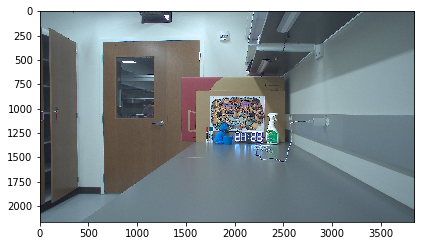

In [10]:
#camera = 0
[pop, dist, maxp, idx, pip] = autoexposure(sid = camera, max_exposure = 0.1, num_intervals = 10)
imio.imshow(pip)

124.65378580729167


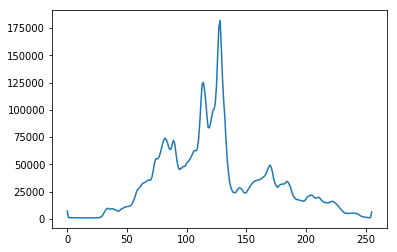

In [11]:
hist = np.histogram(np.hstack(pip[:, :, 1]), bins = 256)
print(np.average(np.hstack(pip[:, :, 1])))
plt.plot(hist[0])